In [30]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [31]:
df = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


In [33]:
df.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

In [34]:
# Simple Imputing
imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['SES']])
df[['SES']] = imputer.fit_transform(df[['SES']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['CDR']])
df[['CDR']] = imputer.fit_transform(df[['CDR']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['MMSE']])
df[['MMSE']] = imputer.fit_transform(df[['MMSE']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['Educ']])
df[['Educ']] = imputer.fit_transform(df[['Educ']])

In [35]:
df.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ       0
SES        0
MMSE       0
CDR        0
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

In [36]:
df.drop(columns=['ID','Delay'],inplace=True)
df['CDR'].value_counts()

0.0    336
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [37]:
df.loc[df['CDR'] == 0.5,'CDR'] = 1
df.loc[df['CDR'] == 2,'CDR'] = 1

In [38]:
df['CDR'].value_counts()

0.0    336
1.0    100
Name: CDR, dtype: int64

In [39]:
y = df.pop('CDR')
x = df

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 24,test_size=0.2, stratify = y)

In [41]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0.0: 0.6492537313432836, 1.0: 2.175}

In [42]:
# ohe = OneHotEncoder(sparse=False)
# y_train = np.array([[i] for i in y_train])
# y_test = np.array([[i] for i in y_test])
# y_train = ohe.fit_transform(y_train)
# y_test = ohe.transform(y_test)

# Label Encoding
le = LabelEncoder()
X_train['Hand'] = le.fit_transform(X_train['Hand'].values)
X_test['Hand'] = le.transform(X_test['Hand'].values)
le = LabelEncoder()
X_train['M/F'] = le.fit_transform(X_train['M/F'].values)
X_test['M/F'] = le.transform(X_test['M/F'].values)

In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
input_layer = keras.Input(shape = (X_train.shape[1]))
x = layers.Dense(16, activation='relu')(input_layer)
x1 = layers.Dense(16, activation='relu')(x)
x2 = layers.Dense(16, activation='relu')(x)
x3 = layers.Dense(16, activation='relu')(x)
x4 = layers.Concatenate()([x1, x2, x3])
x5 = layers.Dense(16, activation='relu')(x3)
x6 = layers.Dense(16, activation='relu')(x2)
x7 = layers.Concatenate()([x1, x5, x6])
x8 = layers.Concatenate()([x, x4, x7])
x9 = layers.Dense(16, activation='relu')(x8)
output = layers.Dense(1, activation="sigmoid")(x9)

model = keras.Model(inputs=input_layer, outputs=output)
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True) 
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"])

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 16)           160         input_3[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 16)           272         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 16)           272         dense_16[0][0]                   
____________________________________________________________________________________________

In [46]:
sm = SMOTE(random_state=72)
x_smote, y_smote = sm.fit_resample(X_train, y_train)

In [47]:
x_smote.shape, y_smote.shape

((536, 9), (536,))

In [48]:
x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state=73, stratify = y_smote)

In [49]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train_smote, y_train_smote))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_smote, y_val_smote))

batch_size = 16
train_dataset = (
    train_loader.shuffle(len(x_train_smote))
    .batch(batch_size)
    .prefetch(16)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val_smote))
    .batch(batch_size)
    .prefetch(16)
)

In [50]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "text_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [51]:
epochs = 100
model_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
27/27 [==============================] - 1s 10ms/step - loss: 0.6847 - acc: 0.5701 - val_loss: 0.6329 - val_acc: 0.6852
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 0.6590 - acc: 0.6192 - val_loss: 0.6086 - val_acc: 0.7130
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 0.6351 - acc: 0.6776 - val_loss: 0.5878 - val_acc: 0.7407
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 0.6130 - acc: 0.7430 - val_loss: 0.5688 - val_acc: 0.7778
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 0.5925 - acc: 0.7757 - val_loss: 0.5507 - val_acc: 0.8056
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 0.5730 - acc: 0.7921 - val_loss: 0.5327 - val_acc: 0.8241
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 0.5542 - acc: 0.8014 - val_loss: 0.5160 - val_acc: 0.8241
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 0.5366 - 

In [52]:
model.load_weights("text_classification.h5")

In [53]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.8295454382896423
Test Loss: 0.272460013628006


In [54]:
y_pred = model.predict(X_test)

In [56]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [57]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88        68
           1       0.58      0.90      0.71        20

    accuracy                           0.83        88
   macro avg       0.77      0.85      0.79        88
weighted avg       0.88      0.83      0.84        88



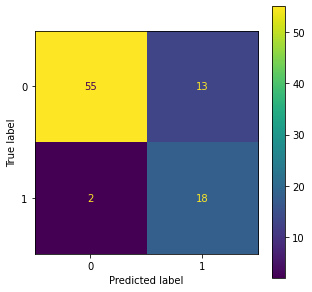

In [58]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [59]:
# Test on SMOTE
nsm = SMOTE(random_state=42)
x_test_smote, y_test_smote = nsm.fit_resample(X_test, y_test)

In [60]:
y_pred_smote = model.predict(x_test_smote)

y_pred_dash = []
y_test_dash = []

for i in list(y_pred_smote):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_pred_dash.append(k)

for i in list(y_test_smote):
#     t = list(i)
#     k = t.index(max(t))
    k = 0 if i < 0.5 else 1
    y_test_dash.append(k)

In [61]:
print(classification_report(y_test_dash, y_pred_dash))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87        68
           1       0.83      0.96      0.89        68

    accuracy                           0.88       136
   macro avg       0.89      0.88      0.88       136
weighted avg       0.89      0.88      0.88       136



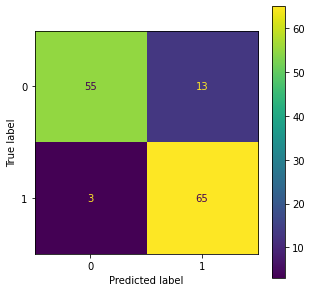

In [62]:
cm = confusion_matrix(y_test_dash, y_pred_dash)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [63]:
history = model_history.history

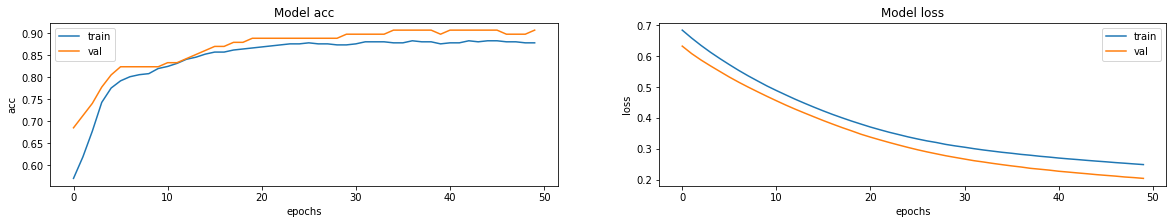

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history[metric])
    ax[i].plot(history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])